In [1]:
from cloudvolume import CloudVolume
from skimage.transform import downscale_local_mean
import napari
from skimage import io
import random
import h5py
from skimage import measure
from brainlit.preprocessing import removeSmallCCs
import numpy as np 
import matplotlib.pyplot as plt 
import subprocess
import tables
from napari_animation import AnimationWidget
from tqdm import tqdm
import pickle
from parse_ara import *
import networkx as nx
import seaborn as sns
import pandas as pd
import brainrender
import scipy.ndimage as ndi
from skimage.morphology import skeletonize
from axon_data import brain2paths, brain2centers
import os
from util import json_to_points
%gui qt5

/Users/thomasathey/Documents/mimlab/mouselight/docs_env/lib/python3.8/site-packages/nilearn/datasets/__init__.py:86: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  warn("Fetchers from the nilearn.datasets module will be "


embedWindow(verbose=True): could not load ipyvtk_simple try:
> pip install -U git+https://github.com/Kitware/ipyvtk-simple.git


# Download benchmark data

In [ ]:
brain = "3"

base_dir = "/Users/thomasathey/Documents/mimlab/mouselight/ailey/benchmark_formal/brain" + brain + "/"

centers_train = brain2centers[brain][0]
centers_val = brain2centers[brain][0] #annotate z slice 25, 50 and 75
print(f"{len(centers_train)} training samples, {len(centers_val)} val samples")

mip = 0

dir = brain2paths[brain]["ab"]
vol_fg = CloudVolume(dir, parallel=1, mip=mip, fill_missing=False)
dir = brain2paths[brain]["bg"]
vol_bg = CloudVolume(dir, parallel=1, mip=mip, fill_missing=False)
dir = brain2paths[brain]["endo"]
vol_endo = CloudVolume(dir, parallel=1, mip=mip, fill_missing=False)
dir = brain2paths[brain]["mask"]
vol_mask = CloudVolume(dir, parallel=1, mip=mip, fill_missing=True)

print(vol_bg.shape)



### download training data

In [ ]:
dataset_to_save = "val"

if dataset_to_save == "train":
    centers = centers_train
elif dataset_to_save == "val":
    centers = centers_val
else:
    raise ValueError("invalid dataset")

for i, center in enumerate(centers_train):
    if i < 7:
        continue
    image_fg = vol_fg[center[0]-49:center[0]+50,center[1]-49:center[1]+50, center[2]-49:center[2]+50]
    image_fg = image_fg[:,:,:,0]

    image_bg = vol_bg[center[0]-49:center[0]+50,center[1]-49:center[1]+50, center[2]-49:center[2]+50]
    image_bg = image_bg[:,:,:,0]

    image_endo = vol_endo[center[0]-49:center[0]+50,center[1]-49:center[1]+50, center[2]-49:center[2]+50]
    image_endo = image_endo[:,:,:,0]


    image_2channel = np.stack([image_bg, image_fg, image_endo], axis=0)
    
    fname =base_dir + dataset_to_save + "_" + str(i) + ".h5"
    with h5py.File(fname, "w") as f:
        dset = f.create_dataset("image_2channel", data=image_2channel)    

## View data

In [ ]:
center = centers_train[2]

image_fg = vol_fg[center[0]-49:center[0]+50,center[1]-49:center[1]+50, center[2]-49:center[2]+50]
image_fg = image_fg[:,:,:,0]

image_bg = vol_bg[center[0]-49:center[0]+50,center[1]-49:center[1]+50, center[2]-49:center[2]+50]
image_bg = image_bg[:,:,:,0]

image_endo = vol_endo[center[0]-49:center[0]+50,center[1]-49:center[1]+50, center[2]-49:center[2]+50]
image_endo = image_endo[:,:,:,0]

viewer = napari.Viewer(ndisplay=3)
viewer.add_image(image_fg)
viewer.add_image(image_bg)
viewer.add_image(image_endo)

In [ ]:

files = os.listdir(base_dir)
files = [base_dir+f for f in files if "val" in f]
files = [f for f in files if "Labels.h5" in f]

num_pos_voxels = 0
for fname in files:
    f = h5py.File(fname, 'r')
    gt = f.get('exported_data')
    gt = gt[0,:,:,:]
    pos_labels = gt == 2
    num_pos_voxels += np.sum(pos_labels)

print(num_pos_voxels)

## Check training results

In [ ]:
true_pos_total = 0
false_pos_total = 0
true_labels_total = 0

files = os.listdir(base_dir)
files = [base_dir+f for f in files if "train" in f]
#need to filter for labels/probs fiiles

for fname in files:
    f = h5py.File(fname, 'r')
    im = f.get('image_2channel')
    im_bg = im[0,:,:,:]
    im_fg = im[1,:,:,:]
    im_endo = im[2,:,:,:]

    fname = base_dir + "train_" + str(i) + "-image_2channel_Labels.h5"
    f = h5py.File(fname, 'r')
    gt = f.get('exported_data')
    gt = gt[0,:,:,:]
    pos_labels = gt == 2
    num_pos_labels = np.sum(pos_labels)

    fname = base_dir + "train_" + str(i) + "-image_2channel_Probabilities.h5"
    f = h5py.File(fname, 'r')
    seg = f.get('exported_data')
    seg = seg[1,:,:,:]
    mask = seg > 0.5

    true_pos = np.sum(np.logical_and(mask, pos_labels))
    true_pos_total += true_pos
    false_pos = np.sum(np.logical_and(mask, gt == 1))
    false_pos_total += false_pos
    true_labels = np.sum(pos_labels)
    true_labels_total += true_labels
    
    if num_pos_labels > 0:
        precision = true_pos/(true_pos + false_pos)
        recall = true_pos/true_labels
        print(f"Example {i}: precision: {precision}, recall: {recall}")
    else:
        print(f"Example {i}: 0 positive labels, false positive rate is: {false_pos/np.sum(gt == 1)}")

    '''
    viewer = napari.Viewer(ndisplay=3)
    viewer.add_image(im_bg)
    viewer.add_image(im_fg)
    viewer.add_labels(gt)
    viewer.add_labels(mask)
    '''
print(f"Total precision: {true_pos_total/(true_pos_total + false_pos_total)} total recall: {true_pos_total/true_labels_total} with {true_labels_total} total positive voxels")

## Check Val results

In [ ]:
spacing =  0.02
thresholds = np.arange(spacing, 1.0, spacing)
precisions = []
recalls = []
best_fscore = 0

files = os.listdir(base_dir)
files = [base_dir+f for f in files if "val" in f]
files = [f for f in files if "_Probabilities.h5" in f]

print(f"{len(files)} total validation subvolumes")

for threshold in thresholds:
    true_pos_total = 0
    false_pos_total = 0
    true_labels_total = 0
    true_labels_total_neg = 0
    for fname_prob in files:

        fname_im = fname_prob[:-17] + ".h5"
        f = h5py.File(fname_im, 'r')
        im = f.get('image_2channel')
        im_bg = im[0,:,:,:]
        im_fg = im[1,:,:,:]

        fname_lab = fname_prob[:-17] + "-image_2channel_Labels.h5"
        f = h5py.File(fname_lab, 'r')
        gt = f.get('exported_data')
        gt = gt[0,:,:,:]
        pos_labels = gt == 2
        neg_labels = gt == 1

        f = h5py.File(fname_prob, 'r')
        seg = f.get('exported_data')
        seg = seg[1,:,:,:]
        mask = seg > threshold

        true_pos = np.sum(np.logical_and(mask, pos_labels))
        true_pos_total += true_pos
        false_pos = np.sum(np.logical_and(mask, gt == 1))
        false_pos_total += false_pos
        true_labels = np.sum(pos_labels)
        true_labels_total += true_labels
        true_labels_neg = np.sum(neg_labels)
        true_labels_total_neg += true_labels_neg
        
    precision_total = true_pos_total/(true_pos_total + false_pos_total)
    recall_total = true_pos_total/true_labels_total
    fscore = 2/(1/precision_total+1/recall_total)
    print(f"Thresh: {threshold:.2f} --- Total prec.: {precision_total:.3f} total rec.: {recall_total:.3f} w/{true_labels_total}/{true_labels_total_neg} total pos/neg voxels. F-score: {fscore:.4f}")
    if fscore > best_fscore:
        best_fscore = fscore
        best_prec = precision_total
        best_recall = recall_total
        best_threshold = threshold
    precisions.append(precision_total) 
    recalls.append(recall_total)
plt.plot(recalls, precisions, label='Prec-Rec Curve')
plt.scatter([best_recall], [best_prec], c='red', label=f"Best F-score: {best_fscore:.3f} (thresh {best_threshold:.2f})")
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.title(f'Validation Brain {brain} w/{true_labels_total} Total Pos. Voxels')
plt.legend()

In [ ]:
json_to_points("https://viz.neurodata.io/?json_url=https://json.neurodata.io/v1?NGStateID=Tizkn7VMAv6B6Q", round=True)

### Examine best threshold

In [ ]:
for fname_prob in files:
    fname_im = fname_prob[:-17] + ".h5"
    f = h5py.File(fname_im, 'r')
    im = f.get('image_2channel')
    im_bg = im[0,:,:,:]
    im_fg = im[1,:,:,:]
    im_endo = im[2,:,:,:]

    fname_lab = fname_prob[:-17] + "-image_2channel_Labels.h5"
    f = h5py.File(fname_lab, 'r')
    gt = f.get('exported_data')
    gt = gt[0,:,:,:]
    pos_labels = gt == 2

    f = h5py.File(fname_prob, 'r')
    seg = f.get('exported_data')
    seg = seg[1,:,:,:]
    mask = seg > best_threshold

    true_pos = np.sum(np.logical_and(mask, pos_labels))
    true_pos_total += true_pos
    false_pos = np.sum(np.logical_and(mask, gt == 1))
    false_pos_total += false_pos
    true_labels = np.sum(pos_labels)
    true_labels_total += true_labels
    

    precision = true_pos/(true_pos + false_pos)
    recall = true_pos/true_labels
    fscore = 2/(1/precision+1/recall)
    print(f"prec {precision} rec {recall} f {fscore}")
    if fscore < 0.75:
        print(fname_prob)
        name = fname_prob.split("/")[-1]
        viewer = napari.Viewer(ndisplay=3)
        viewer.add_image(im_bg, name=name[:-17])
        viewer.add_image(im_fg)
        viewer.add_image(im_endo)
        viewer.add_labels(gt)
        viewer.add_labels(mask, name=f"p:{precision:.2f} r{recall:.2f}")
        
        

In [ ]:
json_to_points("https://viz.neurodata.io/?json_url=https://json.neurodata.io/v1?NGStateID=V1ZmxgI5NeFOaw", round=True)

# Make annotation layer

In [ ]:

dir = "s3://smartspim-precomputed-volumes/2022_01_14/8613/axon_mask"

info = CloudVolume.create_new_info(
    num_channels    = 1,
    layer_type      = 'segmentation',
    data_type       = 'uint64', # Channel images might be 'uint8'
    encoding        = 'raw', # raw, jpeg, compressed_segmentation, fpzip, kempressed
    resolution      = vol_bg.resolution, # Voxel scaling, units are in nanometers
    voxel_offset    = vol_bg.voxel_offset, # x,y,z offset in voxels from the origin
    # mesh            = 'mesh',
    # Pick a convenient size for your underlying chunk representation
    # Powers of two are recommended, doesn't need to cover image exactly
    chunk_size      = [ 128, 128, 2 ], # units are voxels
    volume_size     = vol_bg.volume_size, # e.g. a cubic millimeter dataset
)
vol_mask = CloudVolume(dir, info=info)
vol_mask.commit_info()

cannot write to https link, can write to s3 link

## Check whole brain results

In [ ]:
#download from cloud
centers = [[2304, 3840, 2100], [2560, 3840, 1800]]

for i,center in enumerate(centers):
    image_fg = vol_fg[center[0]:center[0]+256,center[1]:center[1]+256, center[2]:center[2]+300]
    image_fg = image_fg[:,:,:,0]

    image_bg = vol_bg[center[0]:center[0]+256,center[1]:center[1]+256, center[2]:center[2]+300]
    image_bg = image_bg[:,:,:,0]

    mask_s3 = vol_mask[center[0]:center[0]+256,center[1]:center[1]+256, center[2]:center[2]+300]
    mask_s3 = mask_s3[:,:,:,0]

    image_2channel = np.stack([image_bg, image_fg], axis=0)
    fname = "/Users/thomasathey/Documents/mimlab/mouselight/ailey/benchmark_formal/test_" + str(i) + ".h5"
    with h5py.File(fname, "w") as f:
        dset = f.create_dataset("image_2channel", data=image_2channel)

    

In [ ]:
fname = "/Users/thomasathey/Documents/mimlab/mouselight/ailey/image_0.h5"

subprocess.run(["/Applications/ilastik-1.3.3post3-OSX.app/Contents/ilastik-release/run_ilastik.sh",  "--headless", "--project=/Users/thomasathey/Documents/mimlab/mouselight/ailey/benchmark_formal/matt_benchmark_formal.ilp", fname], stdout=subprocess.PIPE, stderr=subprocess.PIPE)

## Downsample

In [ ]:
#downsample axon mask layer with igneous (this is only partial code, see igneous github for other code snippets)

layer_path = "s3://smartspim-precomputed-volumes/2021_07_15_Sert_Cre_R/axon_mask"

tasks = tc.create_downsampling_tasks(
    layer_path, # e.g. 'gs://bucket/dataset/layer'
    mip=0, # Start downsampling from this mip level (writes to next level up)
    fill_missing=True, # Ignore missing chunks and fill them with black
    axis='z', 
    num_mips=5, # number of downsamples to produce. Downloaded shape is chunk_size * 2^num_mip
    chunk_size=None, # manually set chunk size of next scales, overrides preserve_chunk_size
    preserve_chunk_size=True, # use existing chunk size, don't halve to get more downsamples
    sparse=False, # for sparse segmentation, allow inflation of pixels against background
    bounds=None, # mip 0 bounding box to downsample 
    encoding=None, # e.g. 'raw', 'compressed_segmentation', etc
    delete_black_uploads=False, # issue a delete instead of uploading files containing all background
    background_color=0, # Designates the background color
    compress='gzip', # None, 'gzip', and 'br' (brotli) are options
    factor=(2,2,2), # common options are (2,2,1) and (2,2,2)
  )


In [ ]:
#download higher mip

dir = "precomputed://https://dlab-colm.neurodata.io/2021_07_15_Sert_Cre_R/axon_mask"
vol_mask_ds = CloudVolume(dir, parallel=1, mip=1, fill_missing=False)
print(vol_mask_ds.shape)

data = vol_mask_ds[:,:,0,0]
data = data.astype('int8')
print(data.nbytes)
# print(np.unique(data))
data = data[:,:,:,0]
data = np.swapaxes(data, 0,2) #must do this
print(data.shape)

io.imsave("/Users/thomasathey/Documents/mimlab/mouselight/ailey/wholebrain_results/brain4/register/axon_mask_.tif", data)


## View coronal heat maps

In [ ]:
dir = brain2paths[brain]["mask"]
vol_mask = CloudVolume(dir, parallel=1, mip=3, fill_missing=True)
print(vol_mask.shape)


dir = brain2paths[brain]["atlas"]
vol_atlas = CloudVolume(dir, parallel=1, mip=0, fill_missing=True)
print(vol_atlas.shape)

In [174]:
for z_atlas in range(0, vol_atlas.shape[2], 1000):
    atlas = np.squeeze(vol_atlas[:,:,z_atlas,0])
    mask = np.squeeze(vol_mask[:,:,int(z_atlas/8),0])
    viewer = napari.Viewer(ndisplay=2)
    viewer.add_image(mask)
    viewer.add_labels(atlas)

Downloading: 100%|██████████| 6/6 [00:00<00:00, 27.59it/s]















Downloading: 100%|██████████| 6/6 [00:00<00:00, 26.62it/s]

Downloading: 100%|██████████| 6/6 [00:00<00:00, 19.00it/s]






























Downloading:  17%|█▋        | 1/6 [00:00<00:00,  8.26it/s]


Downloading: 100%|██████████| 6/6 [00:00<00:00, 30.62it/s]




































Downloading:  17%|█▋        | 1/6 [00:00<00:00,  8.30it/s]



Downloading: 100%|██████████| 6/6 [00:00<00:00, 30.35it/s]




















































































In [173]:
mask.shape

(701, 1100, 1, 1)

## Registration

In [ ]:
#downsample
im_path = "/Users/thomasathey/Documents/mimlab/mouselight/ailey/wholebrain_results/brain4/register/registered_2.img"
im = io.imread(im_path)
print(im.shape)
print(np.unique(im))

im = im.astype('float')

im_ds = ndi.zoom(im, (0.4,0.4,0.4))
print(im_ds.shape)
print(np.unique(im_ds))

np.save("/Users/thomasathey/Documents/mimlab/mouselight/ailey/wholebrain_results/brain4/register/registered_3_ds.npy", im_ds)

In [ ]:
im_path = "/Users/thomasathey/Documents/mimlab/mouselight/ailey/wholebrain_results/brain4/register/axon_mask_1_0.tif"
im = io.imread(im_path)
print(im.shape)
print(np.sum(im))

In [ ]:
brain = "brain3"

# im_path = "/Users/thomasathey/Documents/mimlab/mouselight/ailey/wholebrain_results/brain3/register/registered_3_ds.npy"
# im = np.load(im_path)
# print(im.shape)

# im_path = "/Users/thomasathey/Documents/mimlab/mouselight/ailey/wholebrain_results/brain3/register/axon_mask_3.tif"
# im_unreg = io.imread(im_path)
# print(im_unreg.shape)


im_path = "/Users/thomasathey/Documents/mimlab/mouselight/ailey/wholebrain_results/" + brain + "/register/registered_1.img"
im_reg2 = io.imread(im_path)
print(im_reg2.shape)

# im_path = "/Users/thomasathey/Documents/mimlab/mouselight/ailey/wholebrain_results/" + brain + "/register/registered_3.img"
# im_reg3 = io.imread(im_path)
# print(im_reg3.shape)

# vol = CloudVolume(
#     "s3://open-neurodata/ara_2016/sagittal_10um/annotation_10um_2017", mip=0, use_https=True
# )
# print(vol.shape)
# atlas = vol[:,:,:,:]
# atlas = np.squeeze(atlas).T
# print(atlas.shape)
# len(np.unique(atlas))

im_path = "/Users/thomasathey/Documents/mimlab/mouselight/ailey/wholebrain_results/ara_10um.tif"
atlas = io.imread(im_path)
print(atlas.shape)

In [ ]:
smooth = ndi.gaussian_filter(im_reg2.astype('float'), sigma=3)
#smooth = ndi.zoom(smooth, (0.4,0.4,0.4))

In [ ]:
viewer = napari.Viewer(ndisplay=3)
animation_widget = AnimationWidget(viewer)
viewer.window.add_dock_widget(animation_widget, area='right')
#viewer.add_image(im)
viewer.add_image(smooth)
#viewer.add_image(im_reg2)
#viewer.add_image(im_reg3)
viewer.add_labels(atlas)
napari.run() 

In [ ]:
for z in [180, 430, 680, 1030, 1280]:

    slice = atlas[:,:,z]
    slice_data = smooth[:,:,z]#np.sum(im_reg[:,:,z], axis=2)
    mn = np.amin(slice_data)
    print(np.unique(slice_data))
    slice_data[slice == 0] = mn
    labels = measure.label(slice)
    #plt.imshow(labels)

    borders = 0*labels
    for label in np.unique(labels):
        if label != 0:
            mask = np.array(labels == label, dtype='int')
            erode = np.array(ndi.binary_erosion(mask))
            outline = mask - erode
            borders += outline

    print(np.unique(borders))
    borders = borders.astype('float')
    borders_layer = np.zeros((borders.shape[0],borders.shape[1],4))
    for rgba in range(borders_layer.shape[2]):
        borders_layer[:,:,rgba] = borders


    slice_data = ndi.rotate(slice_data, 270)
    plt.imshow(slice_data, cmap='inferno')
    borders_layer = ndi.rotate(borders_layer, 270)
    plt.imshow(borders_layer, cmap='gray')

    fig = plt.gcf()
    fig.set_size_inches(18.5, 10.5)
    fig.savefig('/Users/thomasathey/Desktop/' + str(z) + '.png', dpi=100)

## Atlas readout

In [ ]:
volumes = {}
for x in tqdm(np.arange(0, vol_mask.shape[0], 128)):
    x2 = np.amin([x+128, vol_mask.shape[0]])
    for y in tqdm(np.arange(0, vol_mask.shape[1], 128), leave=False):
        y2 = np.amin([x+128, vol_mask.shape[1]])
        for z in tqdm(np.arange(0, vol_mask.shape[2], 128), leave=False):
            z2 = np.amin([x+128, vol_mask.shape[2]])
            labels = vol_reg[x:x2,y:y2,z:z2]
            labels_unique = np.unique(labels)
            mask = vol_mask[x:x2,y:y2,z:z2]

            for unq in labels_unique:
                if unq in volumes.keys():
                    cur_vol = volumes[unq][1]
                    cur_total = volumes[unq][0]
                else:
                    cur_vol = 0
                    cur_total = 0
                cur_vol += np.sum(mask[labels == unq])
                cur_total += np.sum(labels == unq)
                volumes[unq] = [cur_total, cur_vol]

## Read quantification dictionary

In [2]:
path = "/Users/thomasathey/Documents/mimlab/mouselight/ailey/benchmark_formal/brain3/vol_density.pkl"
with open(path, "rb") as f:
   quantification_dict_3 = pickle.load(f)


path = "/Users/thomasathey/Documents/mimlab/mouselight/ailey/benchmark_formal/brain4/vol_density.pkl"
with open(path, "rb") as f:
   quantification_dict_4 = pickle.load(f)

for key in quantification_dict_4.keys():
   val = quantification_dict_4[key]
   val = [float(v) for v in val]
   val.reverse()
   quantification_dict_4[key] = val

In [3]:
regions = [688, 698, 1089, 583, 477, 803, 703, 1097, 549, 313, 1065]
allen_regions = [315, 698, 1089, 703, 477, 803, 549, 1097, 313, 771, 354, 512] #https://connectivity.brain-map.org/projection/experiment/480074702?imageId=480075280&initImage=TWO_PHOTON&x=17028&y=11704&z=3

In [4]:
quantification_dicts = {"3": quantification_dict_3}#, "4": quantification_dict_4}

In [5]:
f = json.load(open('/Users/thomasathey/Documents/mimlab/mouselight/brainlit_parent/brainlit/experiments/deisseroth/ara_structure_ontology.json','r'))

tree = build_tree(f)
stack = [tree]

In [6]:
queue = [tree]
cur_level = -1
counter = 0
G = nx.DiGraph()
max_level = 0


while len(queue) > 0:
    node = queue.pop(0)
    if node.level > max_level:
        max_level = node.level
    G.add_node(node.id, level = node.level, st_level = node.st_level, name = node.name, acronym = node.acronym, label = str(node.st_level) + ") " +node.name)
    for brain in quantification_dicts.keys():
        G.nodes[node.id][brain + " axon"] = 0
        G.nodes[node.id][brain + " total"] = 0
    if node.parent_id is not None:
        G.add_edge(node.parent_id, node.id)

    queue += node.children

i_test = 0
print(f"Max level: {max_level}")
print(G.nodes[997][list(quantification_dicts.keys())[i_test] + " axon"])
print(G.nodes[997][list(quantification_dicts.keys())[i_test] + " total"])
for brain,quantification_dict in quantification_dicts.items():
    for key in quantification_dict.keys():
        if key in G.nodes:
            G.nodes[key][brain + " axon"] = G.nodes[key][brain + " axon"] + float(quantification_dict[key][1])
            G.nodes[key][brain + " total"] = G.nodes[key][brain + " total"] + float(quantification_dict[key][0])
print(G.nodes[997][list(quantification_dicts.keys())[i_test] + " axon"])
print(G.nodes[997][list(quantification_dicts.keys())[i_test] + " total"])

for brain in quantification_dicts.keys():
    for lvl in range(max_level, 0, -1):
        for node in G.nodes:
            if G.nodes[node]['level'] == lvl:
                parent = list(G.in_edges(node))[0][0]
                G.nodes[parent][brain + " axon"] = G.nodes[parent][brain + " axon"] + G.nodes[node][brain + " axon"]
                G.nodes[parent][brain + " total"] = G.nodes[parent][brain + " total"] + G.nodes[node][brain + " total"]
print(G.nodes[997][list(quantification_dicts.keys())[i_test] + " axon"])
print(G.nodes[997][list(quantification_dicts.keys())[i_test] + " total"])

Max level: 10
0
0
1655756.0
379159936.0
1061625709.0
48582134336.0


## pandas + seaborn

In [7]:
import pandas as pd 
import seaborn as sns 
import matplotlib.pyplot as plt 
import xml.etree.ElementTree as ET

In [8]:
totals = {}

for brain in quantification_dicts.keys():
    total = 0
    for node in G.nodes:
        total += G.nodes[node][brain + " axon"]
    totals[brain] = total

axon_vols = []
axon_denss = []
gene = []
subregion_name = []
region_name = []
for region in regions:
    print(f"Populating: " + G.nodes[region]["name"])
    children = list(G.successors(region))
    for child in children:
        for brain in quantification_dicts.keys():
            axon_vols.append(G.nodes[child][brain + " axon"]/totals[brain]*100)
            if G.nodes[child][brain + " total"] == 0 and G.nodes[child][brain + " axon"] == 0:
                axon_denss.append(0)
            elif G.nodes[child][brain + " total"] == 0:
                raise ValueError("positive axon volume in zero volume region?")
            else:
                axon_denss.append(G.nodes[child][brain + " axon"]/G.nodes[child][brain + " total"]*100)

            if brain in ["3" or "4"]:
                gene.append("sert cre")
            subregion_name.append(G.nodes[child]["name"])
            region_name.append(G.nodes[region]["name"])

d = {"Percent Total Axon Volume (%)": axon_vols, "Axon Density (%)": axon_denss, "Gene": gene, "Subregion": subregion_name, "Region": region_name}
df = pd.DataFrame(data = d)


Populating: Cerebral cortex
Populating: Olfactory areas
Populating: Hippocampal formation
Populating: Claustrum
Populating: Striatum
Populating: Pallidum
Populating: Cortical subplate
Populating: Hypothalamus
Populating: Thalamus
Populating: Midbrain
Populating: Hindbrain


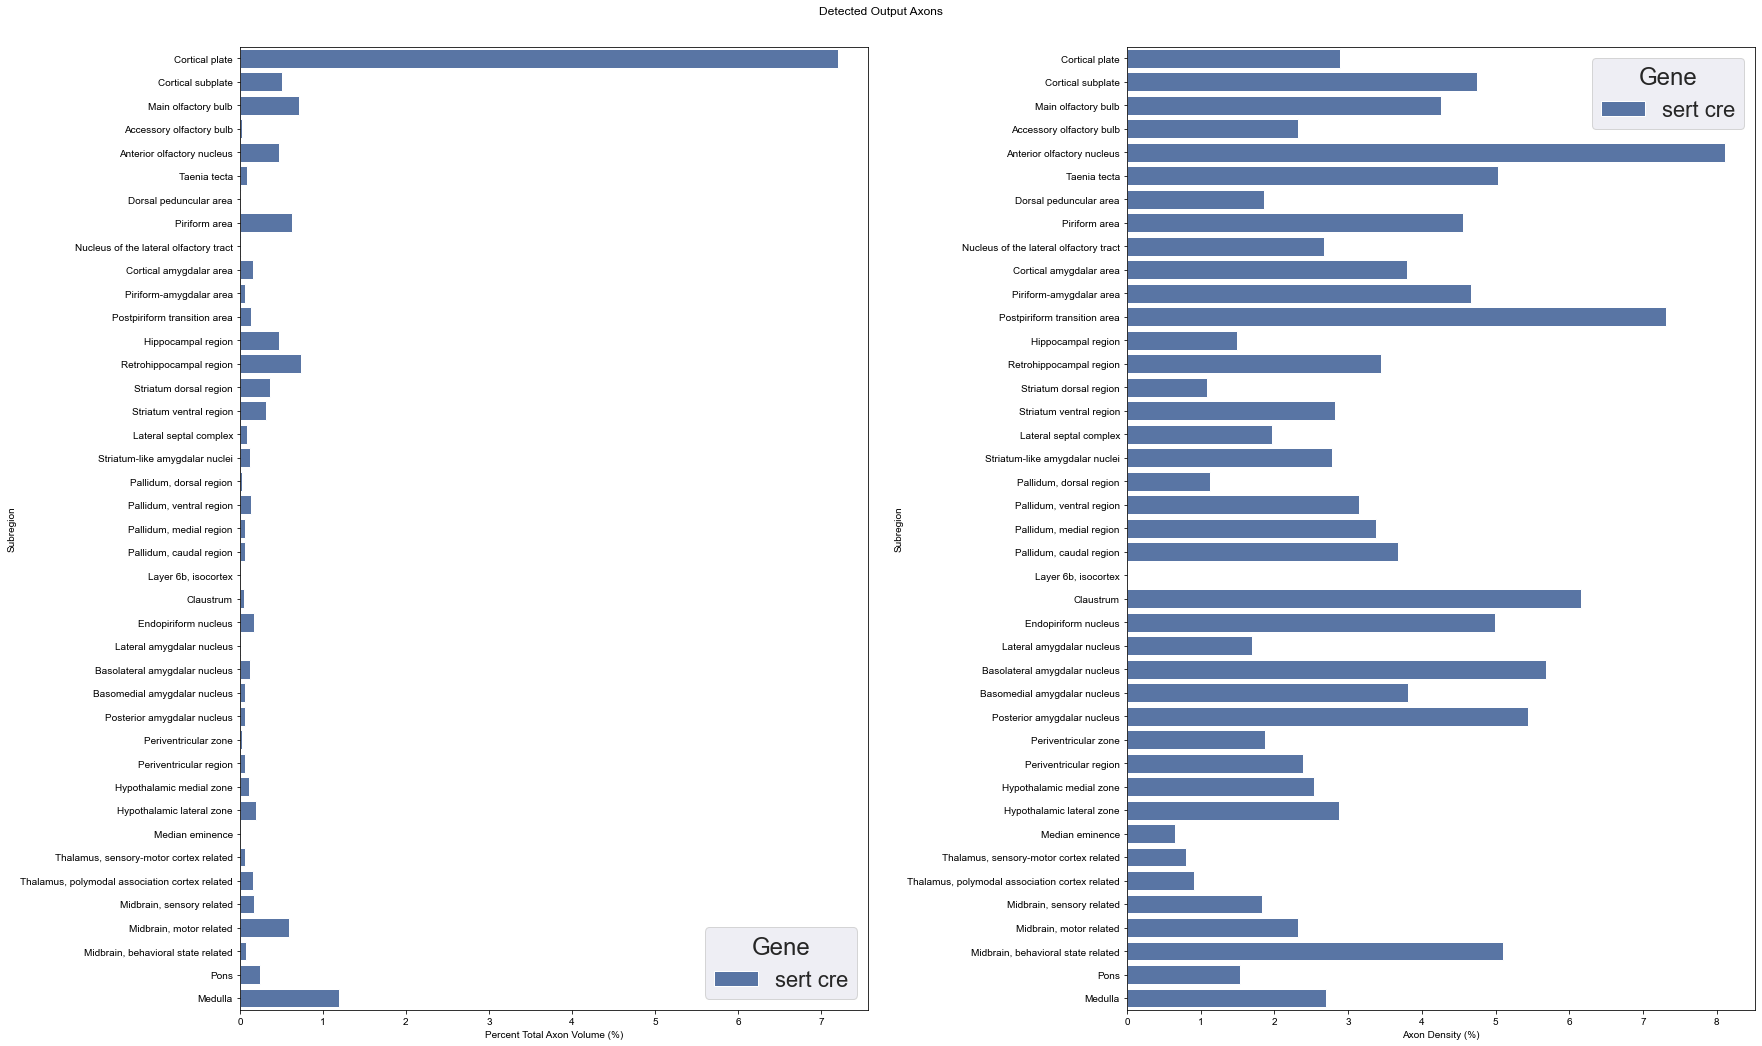

In [9]:
fig, axes = plt.subplots(1, 2, figsize=(25, 15))
fig.suptitle('Detected Output Axons')
sns.set(font_scale=2)

sns.barplot(ax = axes[0], x = "Percent Total Axon Volume (%)", y = "Subregion",  hue= "Gene", data=df)

sns.barplot(ax = axes[1], x = "Axon Density (%)", y = "Subregion",  hue= "Gene", data=df)

fig.tight_layout()

## Compare to Allen

### Region

In [10]:
axon_denss = []
gene = []
subregion_name = []
region_name = []
subregions_list = []
for region in allen_regions:
    print(f"Populating: " + G.nodes[region]["name"])
    children = list(G.successors(region))
    for child in children:
        if child not in subregions_list:
            subregions_list.append(child)


        for brain in quantification_dicts.keys():
            if G.nodes[child][brain + " total"] == 0 and G.nodes[child][brain + " axon"] == 0:
                axon_denss.append(0)
            elif G.nodes[child][brain + " total"] == 0:
                raise ValueError("positive axon volume in zero volume region?")
            else:
                axon_denss.append(G.nodes[child][brain + " axon"]/G.nodes[child][brain + " total"])

            if brain in ["3", "4"]:
                gene.append(brain)
            subregion_name.append(G.nodes[child]["name"])

        
    region_name.append(G.nodes[region]["name"])

tree = ET.parse('/Users/thomasathey/Documents/mimlab/mouselight/brainlit_parent/brainlit/experiments/deisseroth/sert_exp.xml')
root = tree.getroot()
root.tag
for child in root:
    for i, entry in enumerate(child):
        for item in entry:
            if item.tag == "structure-id":
                region = int(item.text)
            elif item.tag == "hemisphere-id":
                hemi = int(item.text)
            elif item.tag == "is-injection":
                inject = item.text
            elif item.tag == "projection-density":
                density = float(item.text)
        if region in subregions_list and hemi == 3 and inject == "false":
            name = G.nodes[region]["name"]
            print(f"id: {region} hemi: {hemi}, density: {density}, name: {name}")
            subregion_name.append(name)
            gene.append("Allen")
            axon_denss.append(density)



d = {"Axon Density": axon_denss, "Gene": gene, "Subregion": subregion_name}
df = pd.DataFrame(data = d)


Populating: Isocortex
Populating: Olfactory areas
Populating: Hippocampal formation
Populating: Cortical subplate
Populating: Striatum
Populating: Pallidum
Populating: Thalamus
Populating: Hypothalamus
Populating: Midbrain
Populating: Pons
Populating: Medulla
Populating: Cerebellum
id: 788 hemi: 3, density: 0.136636874916602, name: Piriform-amygdalar area
id: 386 hemi: 3, density: 0.00940506067532857, name: Medulla, sensory related
id: 835 hemi: 3, density: 0.12281775032477, name: Pallidum, ventral region
id: 254 hemi: 3, density: 0.00398848065726494, name: Retrosplenial area
id: 631 hemi: 3, density: 0.0926450522668481, name: Cortical amygdalar area
id: 339 hemi: 3, density: 0.00227467014511915, name: Midbrain, sensory related
id: 589 hemi: 3, density: 0.105685941866958, name: Taenia tecta
id: 370 hemi: 3, density: 0.00689355889363078, name: Medulla, motor related
id: 159 hemi: 3, density: 0.15646052576407, name: Anterior olfactory nucleus
id: 818 hemi: 3, density: 0.0259834066369393,

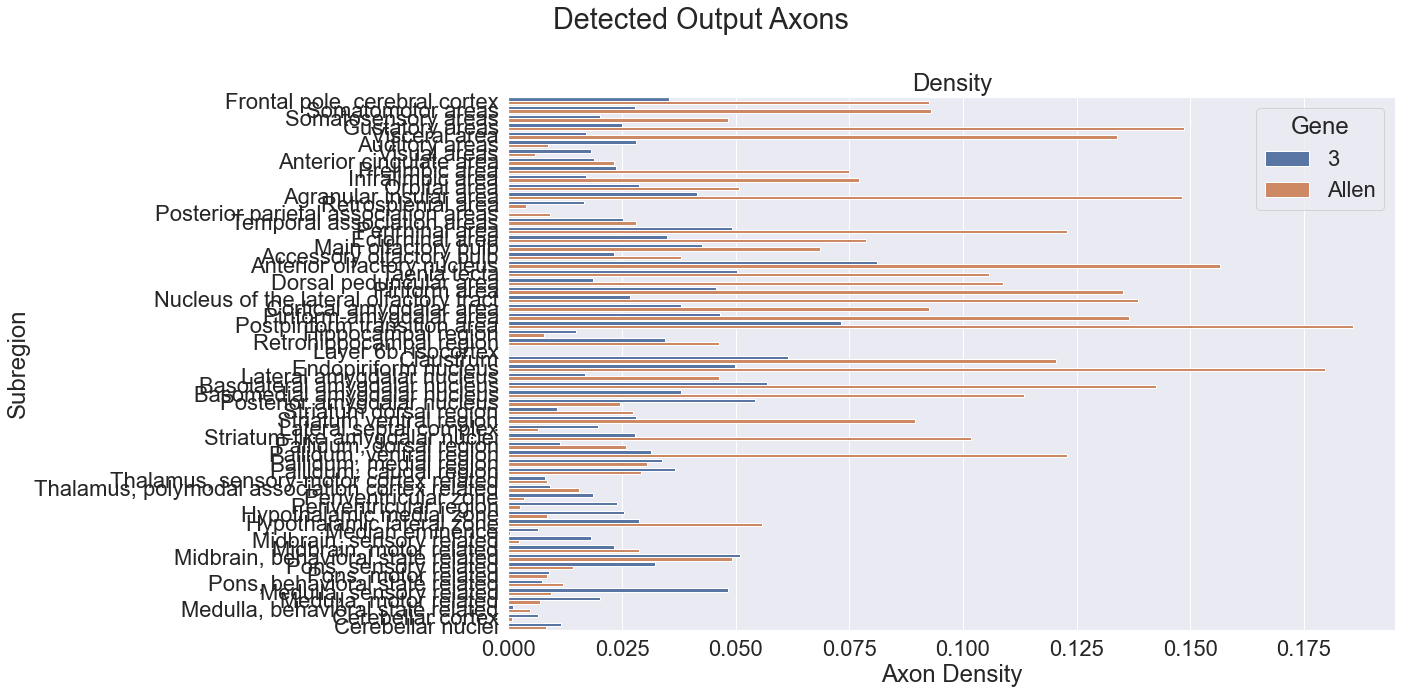

In [11]:
fig, axes = plt.subplots(1, 1, figsize=(20, 10))
fig.suptitle('Detected Output Axons')

sns.barplot(x = "Axon Density", y = "Subregion",  hue= "Gene", data=df)
axes.set_title("Density")

fig.tight_layout()

### Region

In [12]:
axon_denss = []
axon_vols = []
gene = []
region_name = []
for region in allen_regions:
    print(f"Populating: " + G.nodes[region]["name"])
    for brain in quantification_dicts.keys():
        if G.nodes[region][brain + " total"] == 0 and G.nodes[region][brain + " axon"] == 0:
            axon_denss.append(0)
        elif G.nodes[region][brain + " total"] == 0:
            raise ValueError("positive axon volume in zero volume region?")
        else:
            axon_denss.append(G.nodes[region][brain + " axon"]/G.nodes[region][brain + " total"])
            axon_vols.append(G.nodes[region][brain + " axon"]*np.product([1.82,1.82,2])*10**(-9))


        if brain in ["3", "4"]:
            gene.append("Sample " + brain)
        
        region_name.append(G.nodes[region]["name"])

tree = ET.parse('/Users/thomasathey/Documents/mimlab/mouselight/brainlit_parent/brainlit/experiments/deisseroth/sert_exp.xml')
root = tree.getroot()
root.tag
for child in root:
    for i, entry in enumerate(child):
        for item in entry:
            if item.tag == "structure-id":
                region = int(item.text)
            elif item.tag == "hemisphere-id":
                hemi = int(item.text)
            elif item.tag == "is-injection":
                inject = item.text
            elif item.tag == "projection-density":
                density = float(item.text)
            elif item.tag == "projection-volume":
                volume = float(item.text)
        if region in allen_regions and hemi == 3 and inject == "false":
            name = G.nodes[region]["name"]
            print(f"id: {region} hemi: {hemi}, density: {density}, volume: {volume}, name: {name}")
            region_name.append(name)
            gene.append("Allen")
            axon_denss.append(density)
            axon_vols.append(volume)



d = {"Axon Density": axon_denss, "Axon Volume ($mm^3$)": axon_vols, "Gene": gene, "Region": region_name}
df = pd.DataFrame(data = d)


Populating: Isocortex
Populating: Olfactory areas
Populating: Hippocampal formation
Populating: Cortical subplate
Populating: Striatum
Populating: Pallidum
Populating: Thalamus
Populating: Hypothalamus
Populating: Midbrain
Populating: Pons
Populating: Medulla
Populating: Cerebellum
id: 549 hemi: 3, density: 0.013112080557505, volume: 0.293093206, name: Thalamus
id: 354 hemi: 3, density: 0.00688229686428578, volume: 0.234956323, name: Medulla
id: 1097 hemi: 3, density: 0.0272526468213072, volume: 0.4567660048, name: Hypothalamus
id: 698 hemi: 3, density: 0.10608672621099, volume: 5.4622869952, name: Olfactory areas
id: 1089 hemi: 3, density: 0.0245563613157479, volume: 1.1544385888, name: Hippocampal formation
id: 315 hemi: 3, density: 0.0560226948085614, volume: 7.61455387618208, name: Isocortex
id: 703 hemi: 3, density: 0.126879168503671, volume: 1.246075488, name: Cortical subplate
id: 477 hemi: 3, density: 0.0471586351812054, volume: 2.3376713808, name: Striatum
id: 313 hemi: 3, den

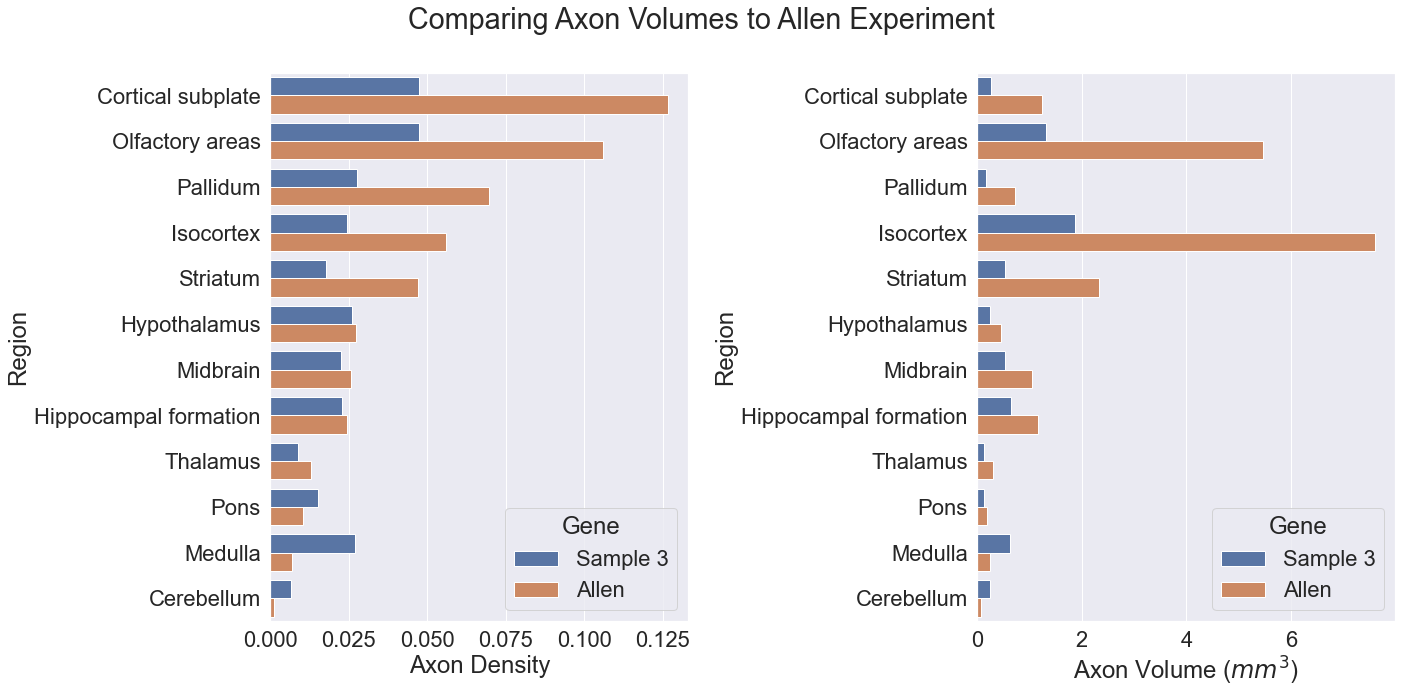

In [13]:
fig, axes = plt.subplots(1, 2, figsize=(20, 10))
fig.suptitle('Comparing Axon Volumes to Allen Experiment')

sns.set(font_scale=2)

sns.barplot(ax = axes[0], x = "Axon Density", y = "Region",  hue= "Gene", order = list(df[df["Gene"] == "Allen"].sort_values('Axon Density', ascending=False).loc[:,'Region']), data=df)
#axes[0].set_title("Density")

sns.barplot(ax = axes[1], x = "Axon Volume ($mm^3$)", y = "Region",  hue= "Gene", order = list(df[df["Gene"] == "Allen"].sort_values('Axon Density', ascending=False).loc[:,'Region']), data=df)
#axes[1].set_title("Axon Volume")

fig.tight_layout()